# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [31]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 8

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [32]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

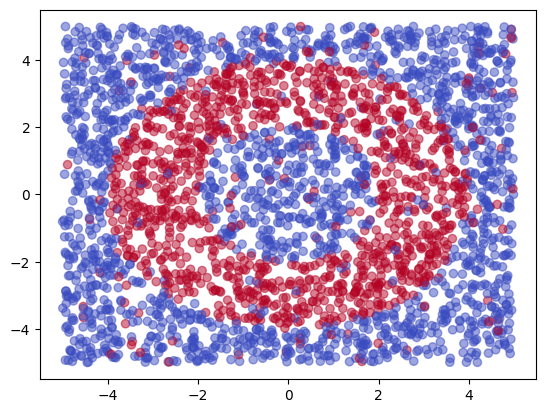

In [33]:
import matplotlib.pyplot as plt
plt.scatter(X_full[:, 0].numpy(), X_full[:, 1].numpy(), c=y_full.numpy(), cmap='coolwarm', alpha=0.5)

In [34]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.3, random_state=GROUP_NUMBER)

# Define constants
input_size = X_train.shape[1]  # Number of features
hidden_size = 16
output_size = 1                # Binary classification
learning_rate = 0.01
num_epochs = 5000

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Input Size: {input_size}, Hidden Size: {hidden_size}, Output Size: {output_size}")
print(f"Learning Rate: {learning_rate}, Number of Epochs: {num_epochs}")

Training data shape: torch.Size([2100, 2]), torch.Size([2100, 1])
Validation data shape: torch.Size([900, 2]), torch.Size([900, 1])
Input Size: 2, Hidden Size: 16, Output Size: 1
Learning Rate: 0.01, Number of Epochs: 5000


In [35]:
W1 = torch.randn(input_size, hidden_size, requires_grad=True)
b1 = torch.zeros(1, hidden_size, requires_grad=True)

W2 = torch.randn(hidden_size, hidden_size, requires_grad=True)
b2 = torch.zeros(1, hidden_size, requires_grad=True)

W3 = torch.randn(hidden_size, hidden_size, requires_grad=True)
b3 = torch.zeros(1, hidden_size, requires_grad=True)

W4 = torch.randn(hidden_size, output_size, requires_grad=True)
b4 = torch.zeros(1, output_size, requires_grad=True)

print("MLP parameters initialized.")

MLP parameters initialized.


In [36]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def binary_cross_entropy_loss(y_pred, y_true):
    epsilon = 1e-7
    y_pred_clipped = torch.clamp(y_pred, epsilon, 1 - epsilon)
    loss = -torch.mean(y_true * torch.log(y_pred_clipped) + (1 - y_true) * torch.log(1 - y_pred_clipped))
    return loss

In [37]:
def forward_pass(x):
    # Hidden Layer 1
    h1_linear = torch.matmul(x, W1) + b1
    h1_activated = sigmoid(h1_linear)

    # Hidden Layer 2
    h2_linear = torch.matmul(h1_activated, W2) + b2
    h2_activated = sigmoid(h2_linear)

    # Hidden Layer 3
    h3_linear = torch.matmul(h2_activated, W3) + b3
    h3_activated = sigmoid(h3_linear)

    # Output Layer
    output = torch.matmul(h3_activated, W4) + b4

    return output

print("Forward pass function defined.")

Forward pass function defined.


In [38]:
def calculate_accuracy(y_pred_logits, y_true):
    y_pred_prob = sigmoid(y_pred_logits)
    y_pred_binary = (y_pred_prob >= 0.5).float()
    accuracy = (y_pred_binary == y_true).float().mean()
    return accuracy

In [39]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# List of parameters to update
parameters = [W1, b1, W2, b2, W3, b3, W4, b4]

for epoch in range(num_epochs):
    # Training Phase
    # Forward pass
    y_pred_train_logits = forward_pass(X_train)
    train_loss = binary_cross_entropy_loss(sigmoid(y_pred_train_logits), y_train)
    train_accuracy = calculate_accuracy(y_pred_train_logits, y_train)

    # Backward pass - compute gradients
    train_loss.backward()

    # Manually update weights and biases using Gradient Descent
    with torch.no_grad(): # Disable gradient calculation for weight updates
        for param in parameters:
            if param.grad is not None:
                param -= learning_rate * param.grad

    # Zero the gradients after updating
    for param in parameters:
        if param.grad is not None:
            param.grad.zero_()

    # Validation Phase
    with torch.no_grad(): # Disable gradient calculation for validation
        y_pred_val_logits = forward_pass(X_val)
        val_loss = binary_cross_entropy_loss(sigmoid(y_pred_val_logits), y_val)
        val_accuracy = calculate_accuracy(y_pred_val_logits, y_val)

    # Record metrics
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_accuracies.append(val_accuracy.item())

    # Print progress
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss.item():.4f}, Train Acc: {train_accuracy.item():.4f}, "
              f"Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy.item():.4f}")

print("MLP training complete.")

Epoch [500/5000], Train Loss: 0.6716, Train Acc: 0.6124, Val Loss: 0.6815, Val Acc: 0.5900
Epoch [1000/5000], Train Loss: 0.6693, Train Acc: 0.6124, Val Loss: 0.6801, Val Acc: 0.5900
Epoch [1500/5000], Train Loss: 0.6677, Train Acc: 0.6124, Val Loss: 0.6791, Val Acc: 0.5900
Epoch [2000/5000], Train Loss: 0.6665, Train Acc: 0.6124, Val Loss: 0.6785, Val Acc: 0.5900
Epoch [2500/5000], Train Loss: 0.6655, Train Acc: 0.6124, Val Loss: 0.6779, Val Acc: 0.5900
Epoch [3000/5000], Train Loss: 0.6647, Train Acc: 0.6124, Val Loss: 0.6775, Val Acc: 0.5900
Epoch [3500/5000], Train Loss: 0.6639, Train Acc: 0.6124, Val Loss: 0.6770, Val Acc: 0.5900
Epoch [4000/5000], Train Loss: 0.6633, Train Acc: 0.6124, Val Loss: 0.6766, Val Acc: 0.5900
Epoch [4500/5000], Train Loss: 0.6626, Train Acc: 0.6124, Val Loss: 0.6762, Val Acc: 0.5900
Epoch [5000/5000], Train Loss: 0.6620, Train Acc: 0.6124, Val Loss: 0.6758, Val Acc: 0.5900
MLP training complete.


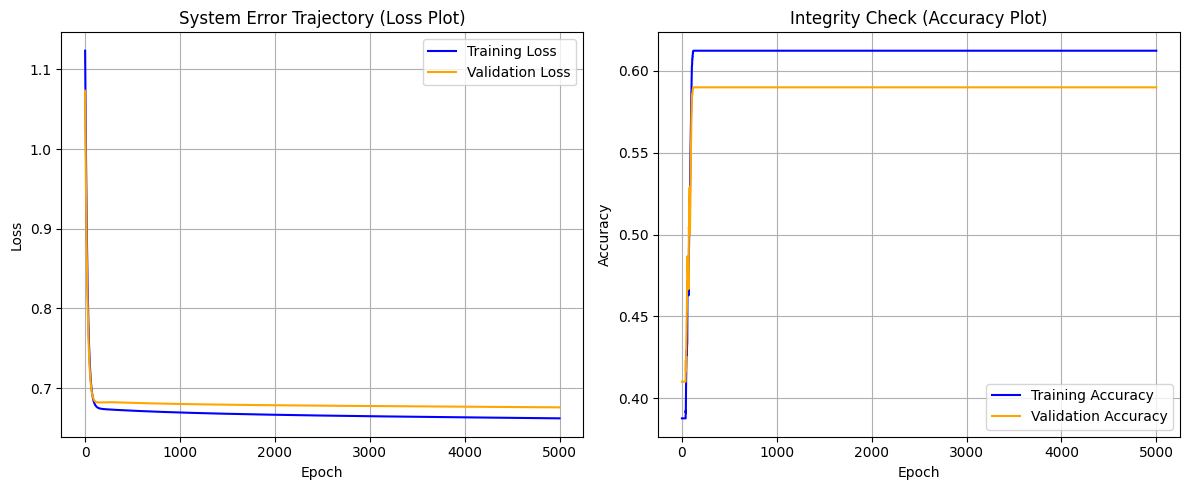

Loss and Accuracy plots generated.


In [40]:
import matplotlib.pyplot as plt

# 1. System Error Trajectory (Loss Plot)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('System Error Trajectory (Loss Plot)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Integrity Check (Accuracy Plot)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Integrity Check (Accuracy Plot)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Loss and Accuracy plots generated.")

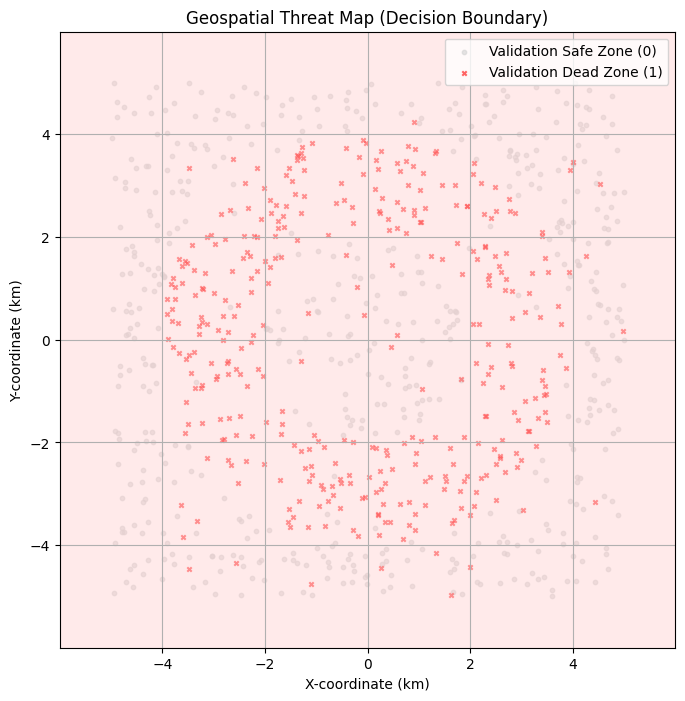

Decision Boundary plot generated.


In [41]:

plt.figure(figsize=(8, 8))

# Plot validation data points
# Separating safe (0) and dead zone (1) points for distinct colors
safe_points_val = X_val[y_val.squeeze() == 0]
dead_zone_points_val = X_val[y_val.squeeze() == 1]

plt.scatter(safe_points_val[:, 0].numpy(), safe_points_val[:, 1].numpy(),
            color='lightgray', marker='o', s=10, label='Validation Safe Zone (0)', alpha=0.6)
plt.scatter(dead_zone_points_val[:, 0].numpy(), dead_zone_points_val[:, 1].numpy(),
            color='red', marker='x', s=10, label='Validation Dead Zone (1)', alpha=0.6)

# Create a meshgrid to plot the decision boundary
x_min, x_max = X_full[:, 0].min() - 1, X_full[:, 0].max() + 1
y_min, y_max = X_full[:, 1].min() - 1, X_full[:, 1].max() + 1
x_grid, y_grid = torch.meshgrid(torch.linspace(x_min, x_max, 100),
                                torch.linspace(y_min, y_max, 100))

xy_grid = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

# Predict probabilities over the grid
with torch.no_grad():
    z = sigmoid(forward_pass(xy_grid)).reshape(x_grid.shape)

# Plot the decision boundary (confidence = 0.5)
plt.contourf(x_grid.numpy(), y_grid.numpy(), z.numpy(), levels=[0, 0.5, 1],
             colors=['#ffcccc', '#ccffcc'], alpha=0.4)
plt.contour(x_grid.numpy(), y_grid.numpy(), z.numpy(), levels=[0.5],
            colors='black', linestyles='dashed', linewidths=2)

plt.title('Geospatial Threat Map (Decision Boundary)')
plt.xlabel('X-coordinate (km)')
plt.ylabel('Y-coordinate (km)')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("Decision Boundary plot generated.")